In [1]:
import numpy as np
import pandas as pd
import nltk
import xgboost as xgb
import string
import seaborn as sns
import matplotlib as plt
color = sns.color_palette()
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize, ngrams
from nltk.classify import SklearnClassifier
eng_stopwords = set(stopwords.words("english"))
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten, merge, LSTM, Lambda, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.layers import Convolution1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import EarlyStopping
np.random.seed(123)

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


At first, in this project, I used n-grams method and extracted features using TF-IDF and Count Vectorizer. Then I also tried adding features like number of words/punctuation/stop words/upper cases. I tried naive bayes, random forest, xgboost and neural networks, but the result did not fit too well. Then I decided to use sequences of words as the model and built a model using Sequential() in Keras. I tried preprocessing like removing stop words, stemming and lemmarization. But these techniques did not improve the model fit. I modified the model and tuned parameters to find the model with best performance. In this case, a relatively simple neural network model can perform quite well in classification. It achieved over 85% accuracy rate in the validation dataset.  

In [2]:
train = pd.read_csv("D:/Python/train.csv")
test = pd.read_csv("D:/Python/test.csv")

In [3]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


**Exploratory Analysis**

In [4]:
##Making sure the dataset is not imbalanced
count= train['author'].value_counts()
count

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [5]:
## Number of words in the text 
train["num_words"] = train["text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text 
train["num_unique_words"] = train["text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text 
train["num_chars"] = train["text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text 
train["num_stopwords"] = train["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test["num_stopwords"] = test["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text 
train["num_punctuations"] =train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test["num_punctuations"] =test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text 
train["num_words_upper"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text
train["num_words_title"] = train["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text 
train["mean_word_len"] = train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

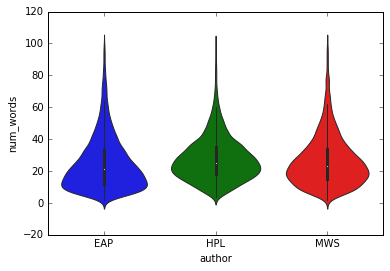

In [6]:
sns.violinplot(x='author', y='num_words', data=train[train['num_words']<=100])

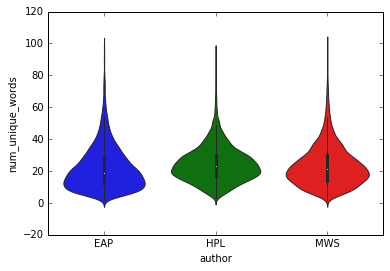

In [7]:
sns.violinplot(x='author', y='num_unique_words', data=train[train['num_unique_words']<=100])

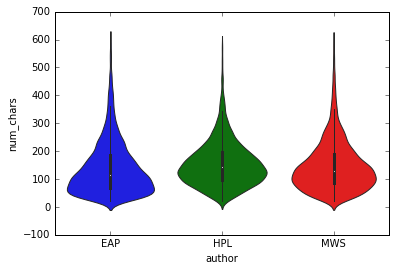

In [8]:
sns.violinplot(x='author', y='num_chars', data=train[train['num_chars']<=600])

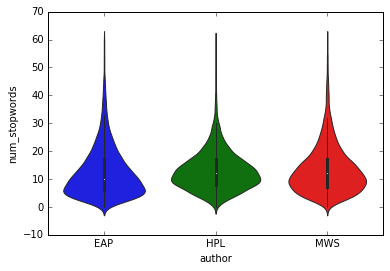

In [9]:
sns.violinplot(x='author', y='num_stopwords', data=train[train['num_stopwords']<=60])

Generally, the number of words/ unique words/ characters/ stop words for EAP is slightly smaller than other two authors.

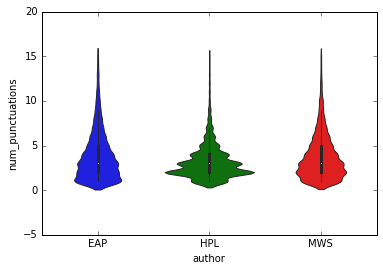

In [10]:
sns.violinplot(x='author', y='num_punctuations', data=train[train['num_punctuations']<=15])

For HPL, the number of punctuations is more densed in smaller values.

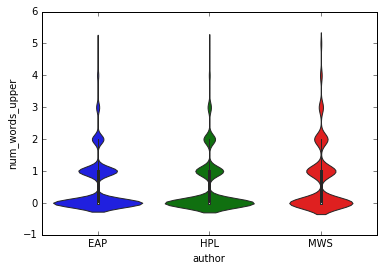

In [11]:
sns.violinplot(x='author', y='num_words_upper', data=train[train['num_words_upper']<=5])

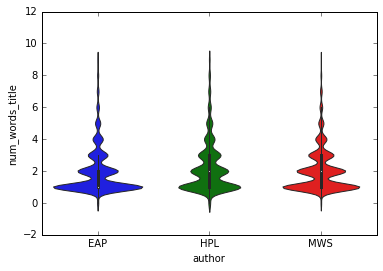

In [12]:
sns.violinplot(x='author', y='num_words_title', data=train[train['num_words_title']<10])

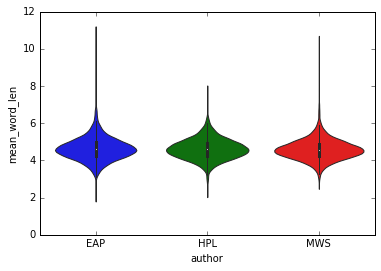

In [13]:
sns.violinplot(x='author', y='mean_word_len', data=train)

There are usually no outliers for mean words length for HPL.  

**Data Preprossing and Feature Extraction**

In [14]:
## Creating Labels
mapping = {'EAP':0, 'HPL':1, 'MWS':2}
train = train.replace({'author':mapping})
train_y = np.array(train['author'])
train_y = np.array(train_y)

In [15]:
##Preprocessing: Remove Punctuations.
train['text'] = train['text'].str.replace('[^\w\s]','')
##Lower cases
train['text'] = train['text'].str.lower()
##Removing stop words reduces the performance metric. One possible explanation is that the use of stop words could be different for these 
##authors and helpful for the classification.  So I kept stop words in the text.

In [16]:
##Creating 2-grams for the sequence.
def add_ngram(q, n_gram_max):
            ngrams = []
            for n in range(2, n_gram_max+1):
                for w_index in range(len(q)-n+1):
                    ngrams.append('--'.join(q[w_index:w_index+n]))
            return q + ngrams
        
n_gram_max = 2
train_n_gram = []
for t in train['text']:
    t = t.split()
    train_n_gram.append(' '.join(add_ngram(t, n_gram_max)))

test_n_gram = []
for t in test['text']:
    t = t.split()
    test_n_gram.append(' '.join(add_ngram(t, n_gram_max)))

In [17]:
train_n_gram[1]

'it never once occurred to me that the fumbling might be a mere mistake it--never never--once once--occurred occurred--to to--me me--that that--the the--fumbling fumbling--might might--be be--a a--mere mere--mistake'

In [18]:
#Determining the maximum sequence length to use
train_num_words = [len(sentence.split()) for sentence in train_n_gram]
pd.DataFrame(train_num_words).quantile(0.999)

0    293.844
Name: 0.999, dtype: float64

In [19]:
#Making sure the test dataset have the similar distribution
test_num_words = [len(sentence.split()) for sentence in test_n_gram]
pd.DataFrame(test_num_words).quantile(0.999)

0    286.744
Name: 0.999, dtype: float64

In [20]:
##Tokenization, Sequencing and Sequence padding
Max_Seq_Len = 300
min_count=2##The word must occur at least two times
tokenizer = Tokenizer(lower=False, filters='')
tokenizer.fit_on_texts(train_n_gram)
num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= min_count])
tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
tokenizer.fit_on_texts(train_n_gram)
train_seq = tokenizer.texts_to_sequences(train_n_gram)
test_seq = tokenizer.texts_to_sequences(test_n_gram)
train_x= pad_sequences(train_seq, maxlen=Max_Seq_Len)
test_x = pad_sequences(test_seq, maxlen=Max_Seq_Len)

In [21]:
##Check the number of words used for building the model.
num_words

69765

In [ ]:
###########1.Creating Features using TFIDF. Not used in the final model.
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [ ]:
###########2.Creating Features using stemmed TFIDF. Not used in the final model.
import Stemmer
english_stemmer = Stemmer.Stemmer('en')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))
s_tfidf = StemmedTfidfVectorizer(stop_words='english', ngram_range=(1,3))

s_tfidf.fit(train['text'].values.tolist() + test['text'].values.tolist())
train_st = s_tfidf .transform(train['text'].values.tolist())
test_st = s_tfidf .transform(test['text'].values.tolist())
##These features did not perform better than using TFIDF only, which may be due to losing information for classification in this scenario.

In [ ]:
#############3.Creating Features using Count Vectorizer. Not used in the final model.
c_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
c_vec.fit(train['text'].values.tolist() + test['text'].values.tolist())
train_c = c_vec.transform(train['text'].values.tolist())
test_c = c_vec.transform(test['text'].values.tolist())
##This performs best among these three feature extraction methods. 


**Model Selection**

In [22]:
##Building the model
model = Sequential()
model.add(Embedding(num_words, 16, input_length=Max_Seq_Len)) ##Using embedding layer to encode words into real-valued vectors.
model.add(GlobalAveragePooling1D()) ##Average Pooling
#model.add(Dropout(0.2)) 
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.fit(train_x, to_categorical(train_y), validation_split=0.15, epochs=17, batch_size= 16)

Train on 16642 samples, validate on 2937 samples
Epoch 1/17
16642/16642 [==============================] - 49s 3ms/step - loss: 1.0763 - acc: 0.4059 - val_loss: 1.0539 - val_acc: 0.4120
Epoch 2/17
16642/16642 [==============================] - 52s 3ms/step - loss: 0.9941 - acc: 0.5123 - val_loss: 0.9418 - val_acc: 0.5451
Epoch 3/17
16642/16642 [==============================] - 55s 3ms/step - loss: 0.8434 - acc: 0.6916 - val_loss: 0.8092 - val_acc: 0.7126
Epoch 4/17
16642/16642 [==============================] - 58s 3ms/step - loss: 0.6950 - acc: 0.7894 - val_loss: 0.7023 - val_acc: 0.7549
Epoch 5/17
16642/16642 [==============================] - 55s 3ms/step - loss: 0.5746 - acc: 0.8337 - val_loss: 0.6228 - val_acc: 0.7746
Epoch 6/17
16642/16642 [==============================] - 51s 3ms/step - loss: 0.4798 - acc: 0.8685 - val_loss: 0.5597 - val_acc: 0.8012
Epoch 7/17
16642/16642 [==============================] - 48s 3ms/step - loss: 0.4032 - acc: 0.8942 - val_loss: 0.5165 - val_acc:

In [23]:
pred = model.predict(test_x)
result = pd.DataFrame()
result['id'] = test['id']
result['EAP'] = [x[0] for x in pred]
result['HPL'] = [x[1] for x in pred]
result['MWS'] = [x[2] for x in pred]
result.to_csv("result.csv", index=False)